多变量时间序列预测的工作原理与单变量时间序列预测类似。主要的区别是，你必须指定要预测的目标单变量的索引，例如，对于一个5个变量的时间序列，你可能想预测第3个变量的值（我们通过指示target_seq_index = 2来指定）

In [162]:
import pandas as pd
import matplotlib.pyplot as plt
from merlion.utils import TimeSeries
from merlion.models.forecast.arima import Arima, ArimaConfig
from merlion.models.forecast.smoother import MSES, MSESConfig
from merlion.models.forecast.baggingtrees import BaggingTreeForecaster,BaggingTreeForecasterConfig

from merlion.transform.base import Identity
from merlion.transform.resample import TemporalResample
from merlion.evaluate.forecast import ForecastMetric
from merlion.models.ensemble.combine import Mean, ModelSelector
from merlion.models.ensemble.forecast import ForecasterEnsemble, ForecasterEnsembleConfig
from merlion.models.factory import ModelFactory

In [163]:
# 读取数据
df = pd.read_csv('Predict_Data_6.csv')
df['month'] = pd.to_datetime(df['month'])
df = df.set_index('month')
df.head()

,closeLogDiff,diff(G1000037)_9_abs,diff(G0008003)_12_abs,diff(G0000029)_12,logDiff(G0001596)_12,P9918147_exp,diff(G1400003)_12_exp
month,,,,,,,
2001-01-01,-0.085514,544.25,0.6,0.6,-0.284451,20.085537,0.485815
2001-02-01,-0.020605,1271.25,0.5,0.5,0.012202,16.444647,0.504234
2001-03-01,0.004219,1225.00,0.4,0.3,-0.232695,16.444647,0.550430
2001-04-01,0.014296,1353.25,0.5,0.3,-0.371287,22.197951,0.717307
2001-05-01,0.015411,2390.50,0.7,0.1,-0.258590,24.532530,0.742841


In [164]:
# 转换格式，划分数据集
time_series_train = TimeSeries.from_pd(df.iloc[:int(df.shape[0]*0.8),:])
time_series_test = TimeSeries.from_pd(df.iloc[int(df.shape[0]*0.8):,:])

In [165]:
df.shape

(244, 7)

In [166]:
time_series_train.shape

(7, 195)

In [167]:
# time_series_test.shape

In [168]:
# 参数
max_forecast_steps  = 100
target_seq_index = 0

In [169]:
# 初始化模型
config1 = ArimaConfig(max_forecast_steps=max_forecast_steps, target_seq_index=target_seq_index, order=(25, 1, 6),transform=Identity())
model1  = Arima(config1)
config2 = MSESConfig(max_forecast_steps=max_forecast_steps, target_seq_index=target_seq_index, max_backstep=60,transform=Identity())
model2  = MSES(config2)


In [170]:
# 集成模型
# selector_config = ForecasterEnsembleConfig(
#     combiner=ModelSelector(metric=ForecastMetric.sMAPE))
# model3 = ForecasterEnsemble(
#     config=selector_config, models=[model1, model2])

In [171]:
for model in [model1]:
    print(f"Training {type(model).__name__}...")
    train_pred, train_stderr = model.train(time_series_train)

Training Arima...


In [172]:
def train_model(model):
    for model in model:
        print(f"Training {type(model).__name__}...")
        train_pred, train_stderr = model.train(time_series_train)

In [173]:
# 训练模型
for model in [model1, model2]:
    print(f"Training {type(model).__name__}...")
    train_pred, train_stderr = model.train(time_series_train)

Training Arima...
Training MSES...


In [174]:
# 提取预测目标
target_univariate = time_series_test.univariates['closeLogDiff']
target = target_univariate[:max_forecast_steps].to_ts()

In [176]:
forecast1, stderr1 = model1.forecast(target.time_stamps)

Arima
RMSE:  0.0355
sMAPE: 115.4556



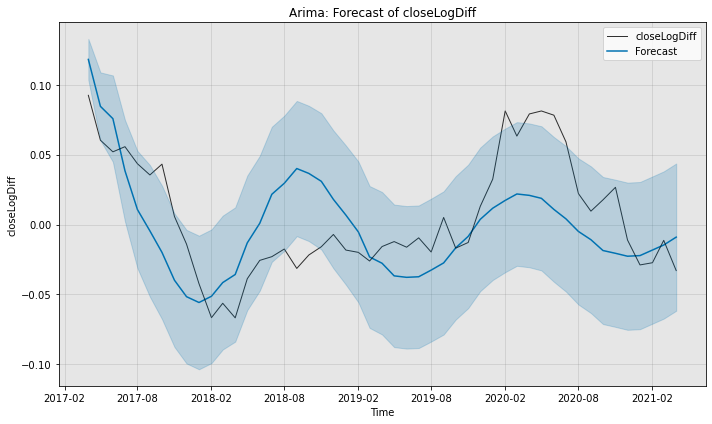

MSES
RMSE:  0.1977
sMAPE: 161.5929



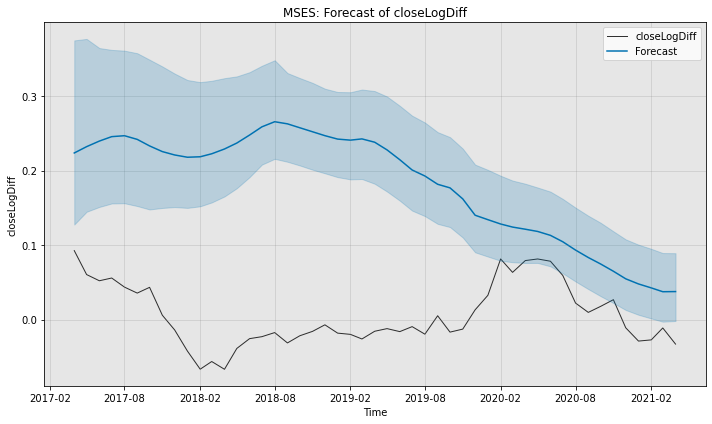

In [175]:
# 预测
for model in [model1, model2]:
    forecast, stderr = model.forecast(target.time_stamps)
    rmse = ForecastMetric.RMSE.value(ground_truth=target, predict=forecast)
    smape = ForecastMetric.sMAPE.value(ground_truth=target, predict=forecast)
    print(f"{type(model).__name__}")
    print(f"RMSE:  {rmse:.4f}")
    print(f"sMAPE: {smape:.4f}")
    print()
    
    # 可视化
    fig, ax = model.plot_forecast(time_series=time_series_test, plot_forecast_uncertainty=True)
    plt.show()

In [177]:
closeLogDiff = forecast1.univariates['closeLogDiff']

In [178]:
test_df = df.iloc[int(df.shape[0]*0.8):,:]

In [179]:
test_df['forcast'] = closeLogDiff

<ipython-input-179-12c3f36209f8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['forcast'] = closeLogDiff


In [180]:
test_df = test_df.drop(labels=['diff(G1000037)_9_abs','diff(G0008003)_12_abs','diff(G0000029)_12','logDiff(G0001596)_12','P9918147_exp','diff(G1400003)_12_exp'],axis=1)

In [182]:
import numpy as np
from sklearn.metrics import accuracy_score

In [184]:
test_df['true_tend']=np.where(test_df.closeLogDiff.diff(periods=1) >= 0, 1, 0)
test_df['pred_tend']=np.where(test_df.forcast.diff(periods=1) >= 0, 1, 0)
test_df['pred_tend'][0]=1

<ipython-input-184-f085eb6017cf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['pred_tend'][0]=1


In [185]:
accuracy_score(test_df['true_tend'],test_df['pred_tend'])

0.5918367346938775

In [190]:
a = len(test_df[test_df['closeLogDiff']>0][test_df['forcast']>0])
b = len(test_df[test_df['closeLogDiff']<0][test_df['forcast']<0])

<ipython-input-190-f292ecdc6cf3>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  a = len(test_df[test_df['closeLogDiff']>0][test_df['forcast']>0])
<ipython-input-190-f292ecdc6cf3>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  b = len(test_df[test_df['closeLogDiff']<0][test_df['forcast']<0])


In [191]:
(a+b)/len(test_df)

0.673469387755102

In [192]:
test_df

,closeLogDiff,forcast,true_tend,pred_tend
month,,,,
2017-04-01,0.092467,0.118150,0,1
2017-05-01,0.060337,0.084574,0,0
2017-06-01,0.052014,0.075764,0,0
2017-07-01,0.055703,0.038489,1,0
2017-08-01,0.043501,0.010701,0,0
2017-09-01,0.035469,-0.004584,0,0
2017-10-01,0.043193,-0.019958,1,0
2017-11-01,0.005753,-0.039870,0,0
2017-12-01,-0.014041,-0.051655,0,0
